In [1]:
import numpy as np
import pylab as plt
import pickle
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm
import umap
from matplotlib.offsetbox import (AnnotationBbox, DrawingArea, OffsetImage,
                                  TextArea)
import h5py
plt.rcParams['font.size'] = 16


/global/homes/a/ashodkh/.conda/envs/my_torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_path = '/global/cfs/cdirs/m4236/cosmosweb/catalogs/hsc_jwst_matched_with_images_high_snr'
f = h5py.File(file_path, 'r')

list(f.keys())


['Confidence_level',
 'bulge_radius',
 'dec',
 'dec_specz',
 'disk_radius',
 'flux_err-cal_model_cfht-u',
 'flux_err-cal_model_f115w',
 'flux_err-cal_model_f150w',
 'flux_err-cal_model_f277w',
 'flux_err-cal_model_f444w',
 'flux_err-cal_model_hsc-g',
 'flux_err-cal_model_hsc-i',
 'flux_err-cal_model_hsc-r',
 'flux_err-cal_model_hsc-y',
 'flux_err-cal_model_hsc-z',
 'flux_model_cfht-u',
 'flux_model_f115w',
 'flux_model_f150w',
 'flux_model_f277w',
 'flux_model_f444w',
 'flux_model_hsc-g',
 'flux_model_hsc-i',
 'flux_model_hsc-r',
 'flux_model_hsc-y',
 'flux_model_hsc-z',
 'hsc_images',
 'id_specz_khostovan25',
 'jwst_images',
 'lephare_photozs',
 'lp_age',
 'lp_mass',
 'lp_sfr',
 'lp_ssfr',
 'lp_type',
 'lp_zpdf_l68',
 'lp_zpdf_u68',
 'mag_model_cfht-u',
 'mag_model_f115w',
 'mag_model_f150w',
 'mag_model_f277w',
 'mag_model_f444w',
 'mag_model_hsc-g',
 'mag_model_hsc-i',
 'mag_model_hsc-r',
 'mag_model_hsc-y',
 'mag_model_hsc-z',
 'photoz',
 'ra',
 'ra_specz',
 'specz']

In [3]:
model_sizes = ['tiny', 'small', 'base', 'large']
n = 5000
telescope = 'hsc'
upsampled = True
dir_out = '/pscratch/sd/a/ashodkh/platonic_universe/embeddings'

embeddings = {}

for model_size in model_sizes:
    if upsampled:
        embeddings[model_size] = np.load(dir_out + f'embeddings_{telescope}_{n}_convnext{model_size}_upsampled_images.npy')
    else:
        embeddings[model_size] = np.load(dir_out + f'embeddings_{telescope}_{n}_convnext{model_size}.npy')


In [4]:
umap_embeddings = {}
for model_size in model_sizes:
    reducer = umap.UMAP(n_components=2)
    umap_embeddings[model_size] = reducer.fit_transform(embeddings[model_size])


In [5]:
mags = []
if telescope == 'hsc':
    bands = ['g', 'r', 'z']
    mags = [f[f'mag_model_hsc-{band}'][:n] for band in bands]
    

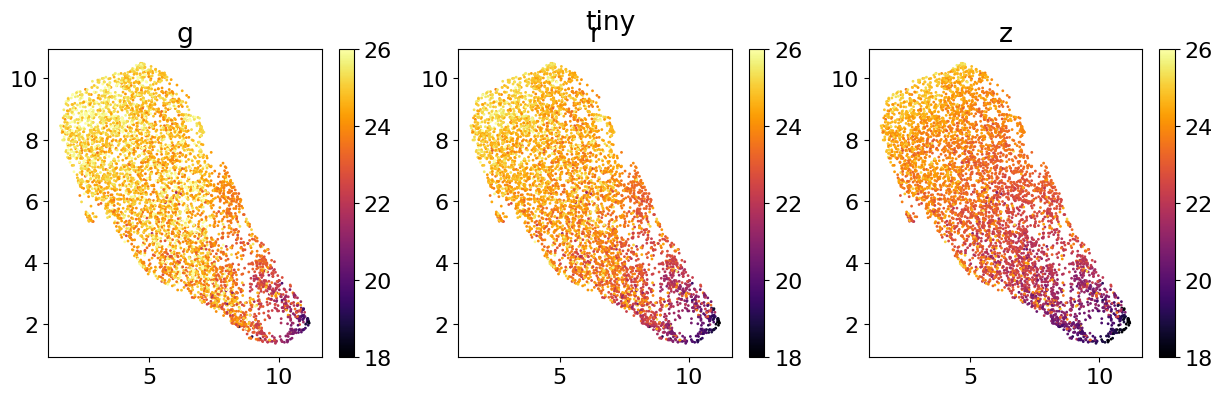

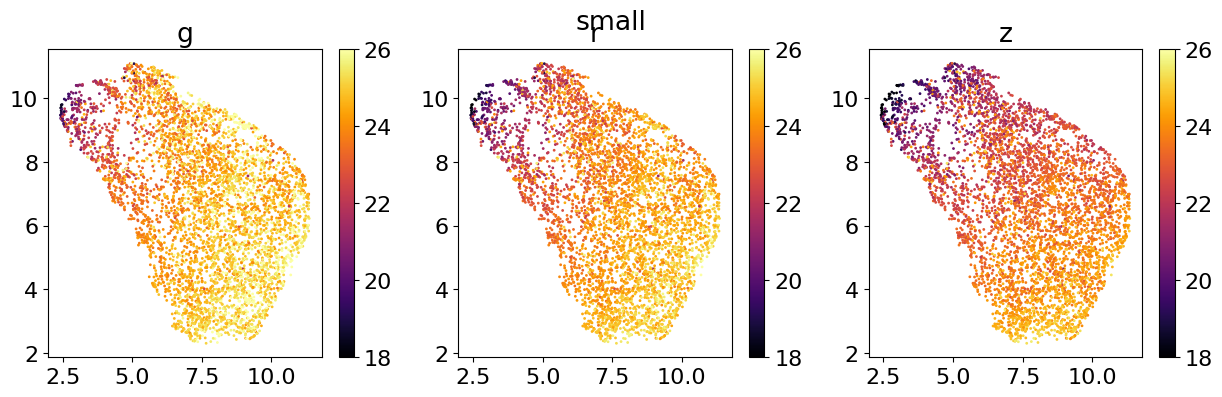

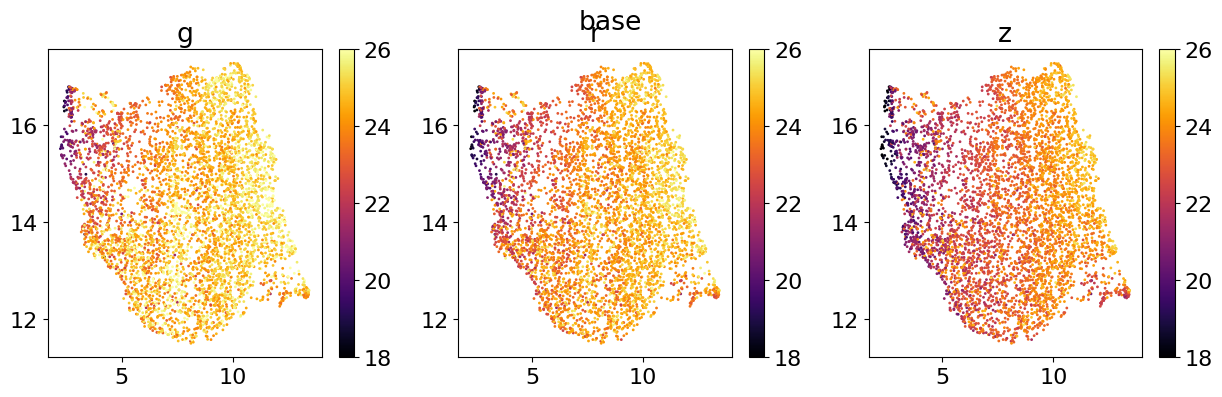

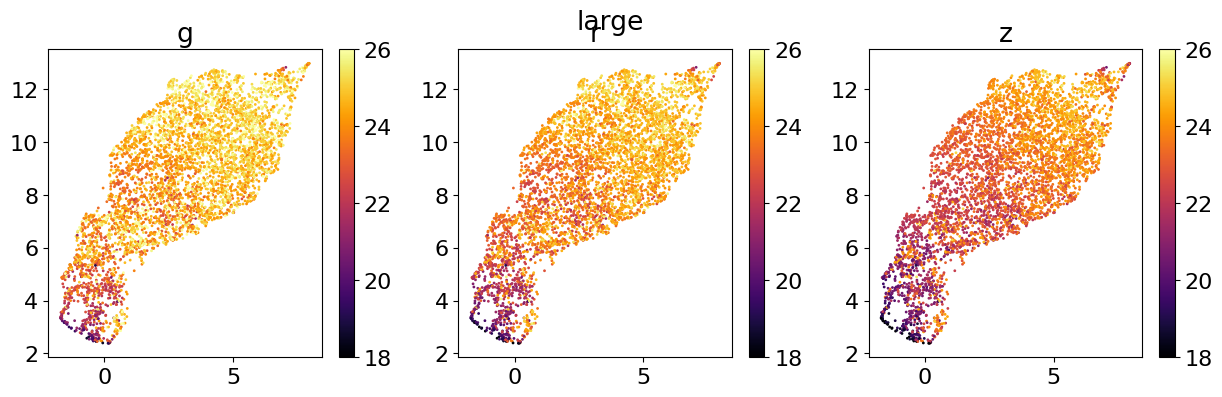

In [6]:
for model_size in model_sizes:
    fig, ax = plt.subplots(ncols=3, figsize=(15,4))
    
    for j, band in enumerate(bands):
        sd = ax[j].scatter(umap_embeddings[model_size][:,0], umap_embeddings[model_size][:,1], c=mags[j], s=1, vmin=18, vmax=26, cmap='inferno');
        ax[j].set_title(band)
        fig.colorbar(sd, ax=ax[j])

    fig.suptitle(model_size)
    